In [1]:
import os
import sys

from pathlib import Path

notebook_dir = Path("C:/Users/Wyss User/Documents/EVs/OLINK/docs")

sys.path.extend([
    str(notebook_dir.parent / "src"),  # Relative path to src folder
    str(Path.home() / "AppData/Local/Packages/PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0/LocalCache/local-packages/Python311/site-packages")
])

from config import hgnc_ids, high_fractions, low_fractions, MISSING_FASTA_SEQUENCES, CELL_TYPES
from brainrnaseq_specificity import map_hgnc_ids, create_enrichment_dataframe, process_hgnc_data
from deeptmhmm_localization import identify_localization, parse_gz_file, get_localization_data
from identify_targets import identify_targets, generate_protein_dataframe, extract_sample_npx
from olink_fractionation import analyze_fractionation
from raw_data_preprocessing import clean_up_raw_data, plot_protein_fractionation, ev_association_score_df, find_ratio, calculate_fractionation_scores
from specificity_functions import calculate_enrichment
from gtex_specificity import gtex_specificity

from io import StringIO

import pandas as pd
import requests


In [2]:
assay_list_path = notebook_dir.parent / "data/231220_ht_panel_assay_list.xlsx"
brain_rna_seq_raw_path = notebook_dir.parent / "data/240411_brain_rna_seq_raw.csv"
output_directory = notebook_dir.parent / "outputs/ht_output"
plate_layout_path = notebook_dir.parent / "data/231204_Walt_Olink_HT_Plate.xlsx"
raw_data = notebook_dir.parent / "data/240214_Walt_Olink_HT_Raw.parquet"
uniprot_fasta_database = notebook_dir.parent / "data/uniprot_fasta_database.gz"
gtex_path = notebook_dir.parent / "data/GTEx_Analysis_v10_RNASeQCv2.4.2_gene_median_tpm.gct.gz"

In [3]:
# Create a tidy dataframe from the raw data file.
tidy_data = clean_up_raw_data(raw_data, plate_layout_path)

In [4]:
# SI Table 4

# Load and process the Brain RNA-Seq data
brain_rna_seq = pd.read_csv(brain_rna_seq_raw_path)
hgnc_uniprot_mapping_data = process_hgnc_data(hgnc_ids)
brain_rna_seq = brain_rna_seq.merge(hgnc_uniprot_mapping_data, left_on="id", right_on="hgnc_id", how="inner").dropna(subset=["uniprot_ids"]).drop_duplicates(subset=["uniprot_ids"])
brain_rna_seq.set_index(["uniprot_ids", "symbol", "name", "alias_symbol", "alias_name"], inplace=True)
expression_df = create_enrichment_dataframe(brain_rna_seq)

# Calculate tau scores and filter by cutoff
tau_score_cutoff = 0.25
enrichment_values = expression_df.apply(lambda row: calculate_enrichment(row, "tau"), axis=1)
high_tau_score = enrichment_values[enrichment_values < tau_score_cutoff]

# Identify proteins with the SEC fractionation pattern indicative of EV association
fractionation_uniprot_ids = analyze_fractionation(tidy_data, high_fractions, low_fractions, sample_health="healthy", mean_median_individual="individual_median")

# Identify protein localizations
fasta_sequences = parse_gz_file(uniprot_fasta_database)
fasta_sequences.update(MISSING_FASTA_SEQUENCES)
assays = pd.read_excel(assay_list_path)
localization_ids = get_localization_data(assays, fasta_sequences, ["TMhelix", "internal", "external"], output_directory)

# Generate categorized protein dataframes
localization_labels = {"internal": "internal", "TMhelix": "transmembrane", "external": "external"}
low_tau_protein_dataframes = {
    label: generate_protein_dataframe(low_tau_score, fractionation_uniprot_ids, localization_ids[loc], label, tidy_data, high_fractions, low_fractions)
    for loc, label in localization_labels.items()
}

int_low_tau = low_tau_protein_dataframes["internal"]
tm_low_tau = low_tau_protein_dataframes["transmembrane"]
ext_low_tau = low_tau_protein_dataframes["external"]

# Concatenate results-- is there a way to create the concatenated dataframe without the intermediate step of creating dictionaries?
low_tau_with_fract_pattern = pd.concat([int_low_tau, tm_low_tau, ext_low_tau])

# Re-name columns
si_table_5 = low_tau_with_fract_pattern.rename(columns={0: "tau_score"})

In [5]:
# SI Table 5 

# Load and process Brain RNA-Seq Data
brain_rna_seq = map_hgnc_ids(hgnc_ids, brain_rna_seq_raw_path)
expression_df = create_enrichment_dataframe(brain_rna_seq)

# Group proteins by sub-cellular localization
localization_types = ["TMhelix", "internal", "external"]
localization_ids = {loc: identify_localization(assays, loc, output_directory) for loc in localization_types}

# Calculate EV association scores for each sub-cellular localization category
localization_results = []

for loc, uniprot_ids in localization_ids.items():
    proteins_with_fract = set(uniprot_ids) & set(fractionation_uniprot_ids)

    fractionation_scores = [
        find_ratio(tidy_data[protein], high_fractions, low_fractions)
        for protein in proteins_with_fract
    ]

    df = pd.DataFrame({
        "uniprot_ids": list(proteins_with_fract),
        "ev_association_score": fractionation_scores,
    })

    df = df.merge(hgnc_uniprot_mapping_data, on="uniprot_ids")
    df["localization"] = loc

    localization_results.append(df)

# Concatenate dataframes
fract_pattern = pd.concat(localization_results, ignore_index=True)

# Calculate tau scores and filter by cutoff
tau_score_cutoff = 0.75
enrichment_values = expression_df.apply(lambda row: calculate_enrichment(row, "tau"), axis=1)
high_tau_score = enrichment_values[enrichment_values > tau_score_cutoff]

filtered_expression_df = expression_df[expression_df.index.isin(high_tau_score.index.tolist())]

# Find proteins that are both specific to a cell type and display the correct fractionation pattern. Label with cell type 
max_col_list = []
uniprots_list = []

for index, row in filtered_expression_df.iterrows():
    max_column = row.idxmax()
    max_col_list.append(max_column)
    uniprots_list.append(index)

cell_type_targets = pd.DataFrame({"cell_type": max_col_list, "uniprot_id": uniprots_list})

si_table_5 = fract_pattern.merge(cell_type_targets, left_on = "uniprot_ids", right_on = "uniprot_id", how = "inner")
high_tau_score = high_tau_score.reset_index()
si_table_5 = si_table_5.merge(high_tau_score, on = "uniprot_ids")

# GTex Specificity to determine the extent to which the proteins are specific to the brain on a body-wide level
gtex_data = gtex_specificity(gtex_path)
si_table_5 = si_table_5.merge(gtex_data, on = "ensembl_gene_id")

si_table_5 = si_table_5.rename(columns={0: "brain_tau_score"})

# this gives a runtime warning-- how do I fix this?

C:\Users\Wyss User\Documents\EVs\OLINK\src\specificity_functions.py:31: RuntimeWarning: invalid value encountered in divide
  row_x = array / max(array)


In [11]:
# generate the data for figure 1d and 1e

# Filter data to include only SEC data collected using a sample from a healthy individual
tidy_data_sec = tidy_data[
    (tidy_data.index.get_level_values("Health") == "Healthy")
    & (tidy_data.index.get_level_values("Sample").str.contains("SEC"))
]

# Extract SEC data for the pre-determined EV associated and contaminant proteins
associated_proteins_df = extract_sample_npx(["P08758", "P07355", "P09525", "Q9NP79"], tidy_data_sec)
contaminant_proteins_df = extract_sample_npx(["P02751", "P00734", "P36955", "P01024"], tidy_data_sec)

associated_proteins = associated_proteins_df.pivot(columns="protein", index="sample")
contaminant_proteins = contaminant_proteins_df.pivot(columns="protein", index="sample")


In [10]:
# identify targets found inside microglia cells that may be EV associated using the raw data file

identify_targets(
    assay_list_path = assay_list_path,
    uniprot_fasta_database = uniprot_fasta_database, 
    brain_rna_seq_raw_path = brain_rna_seq_raw_path,
    region = "internal", 
    cell_type = "microglia", 
    specificity_metric = "tau", 
    specificity_cutoff = 0.75,
    high_fractions = high_fractions, 
    low_fractions = low_fractions, 
    sample_health = 'healthy', 
    mean_median_individual = 'individual_median',
    raw_olink_data_file = raw_data,
    plate_layout_dataframe = plate_layout_path,
    output_directory = output_directory
    )

{'A2A288',
 'P14317',
 'P19838',
 'P57796',
 'Q12802',
 'Q6P0N0',
 'Q6P589',
 'Q7Z6K4',
 'Q9NP95',
 'Q9Y572'}

In [8]:
# identify targets found inside microglia cells that may be EV associated using the tidy dataframe

identify_targets(
    assay_list_path = assay_list_path,
    uniprot_fasta_database = uniprot_fasta_database, 
    brain_rna_seq_raw_path = brain_rna_seq_raw_path,
    region = "internal", 
    cell_type = "microglia", 
    specificity_metric = "tau", 
    specificity_cutoff = 0.75,
    high_fractions = high_fractions, 
    low_fractions = low_fractions, 
    sample_health = 'healthy', 
    mean_median_individual = 'individual_median',
    plate_layout_dataframe = plate_layout_path,
    tidy_dataframe = tidy_data,
    output_directory = output_directory
    )

{'A2A288',
 'P14317',
 'P19838',
 'P57796',
 'Q12802',
 'Q6P0N0',
 'Q6P589',
 'Q7Z6K4',
 'Q9NP95',
 'Q9Y572'}

<Axes: title={'center': 'Healthy Q9Y251 Fractionation Pattern, HT Panel'}, xlabel='Sample Description', ylabel='Delta'>

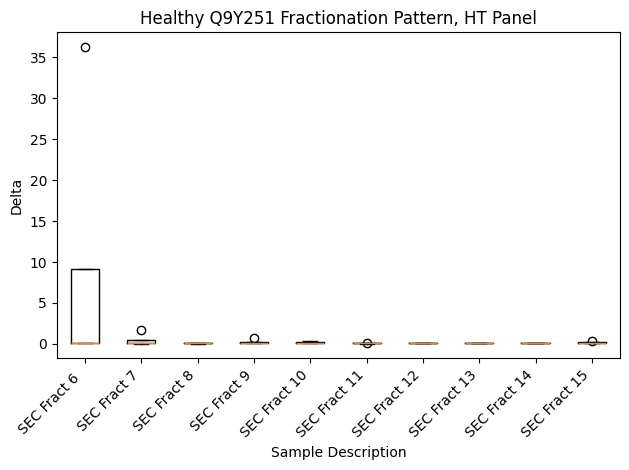

In [9]:
# make a box-and-whisker plot for a target of interest

plot_protein_fractionation(tidy_data, "Q9Y251")